# Importaciones

In [31]:
import pandas as pd
import numpy as np
#from yellowbrick.classifier import ROCAUC #Calcular curva ROC con multiclass
#import shap as shap #XAI comprobar peso de variables en modelo
from sklearn.tree import DecisionTreeClassifier, export_graphviz # Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier #Algoritmo randomforest de clasificación
from sklearn.model_selection import train_test_split #Import train_test_split function
import matplotlib.pyplot as plt #Representación de gráficos
#from sklearn.model_selection import GridSearchCV #Búsqueda de parámetros para validación cruzada
from sklearn.model_selection import StratifiedKFold #División en k para validación cruzada
from sklearn.model_selection import cross_val_score #Validación cruzada
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score, classification_report, 
                            matthews_corrcoef, roc_auc_score,  f1_score, accuracy_score, 
                            recall_score, precision_score, ConfusionMatrixDisplay) #Métricas
#Representación gráfica de árboles de decisión
import pydotplus
import matplotlib.image as pltimg
from sklearn import tree
from imblearn.over_sampling import SMOTE

#import pydotplus
#import matplotlib.pyplot as plt


# Compensación de las clases y generación de datos artificiales

In [13]:
# Cargar el dataset
data = pd.read_csv(r'DATA_SELECTED_VALUES_SINFPB.csv')

In [14]:
# Separar las características (X) y la variable objetivo (y)
X = data.drop(columns='PROMOCIONA')
y = data['PROMOCIONA']

# Aplicar SMOTE para aumentar las muestras equiparando clases - balanceo
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convertir a DataFrame
data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
data_resampled['PROMOCIONA'] = y_resampled

# Verificar y listar las columnas
print("Columnas del DataFrame:")
print(data.columns)

# Identificar las columnas binarias, ordinales y otras numéricas
binary_columns = [col for col in X.columns if set(data[col].unique()).issubset({0, 1})]
decimal_columns = ['1ESO_MEDIA_1EV', '1ESO_MEDIA_EVF']  # Columnas numéricas con decimales
ordinal_columns = ['A_IDIOMA_NVL', 'P_ESTUDIOS']  # Columnas ordinales
integer_columns = [col for col in X.columns if col not in binary_columns + decimal_columns + ordinal_columns]

# Crear datos artificiales mediante réplicas con perturbaciones adecuadas
def create_perturbations(df, binary_cols, decimal_cols, ordinal_cols, integer_cols, n_copies=5, noise_level=0.01):
    data_augmented = df.copy()
    for i in range(n_copies):
        noisy_data = df.copy()
        for column in decimal_cols:
            if df[column].dtype in [np.float64, np.int64]:  # Aplicar ruido solo a columnas numéricas con decimales
                noise = np.random.normal(0, noise_level, size=df[column].shape)
                noisy_data[column] += noise
        for column in integer_cols:
            if df[column].dtype in [np.float64, np.int64]:  # Aplicar ruido a columnas de enteros y redondear
                noise = np.random.normal(0, noise_level, size=df[column].shape)
                noisy_data[column] = np.round(noisy_data[column] + noise).astype(int)
        for column in ordinal_cols:
            if column == 'A_IDIOMA_NVL':  # Asegurar límites de 1, 2, 3
                noise = np.random.normal(0, noise_level, size=df[column].shape)
                noisy_data[column] = np.clip(np.round(noisy_data[column] + noise).astype(int), 1, 3)
            elif column == 'P_ESTUDIOS':  # Asegurar límites de 1 a 7
                noise = np.random.normal(0, noise_level, size=df[column].shape)
                noisy_data[column] = np.clip(np.round(noisy_data[column] + noise).astype(int), 1, 7)
        data_augmented = pd.concat([data_augmented, noisy_data], axis=0)
    return data_augmented

data_augmented = create_perturbations(data_resampled, binary_columns, decimal_columns, ordinal_columns, integer_columns, n_copies=30, noise_level=0.01)

# Asegurarse de que las columnas binarias sigan siendo binarias
for column in binary_columns:
    data_augmented[column] = data_augmented[column].round().clip(0, 1)

data_augmented

#Se balancean las clases y se aumenta el dataset a 1178 observaciones.

Columnas del DataFrame:
Index(['A_IDIOMA_NVL', 'P_PAIS_OTRO_NO_EU', 'P_PAIS_ESPAÑA',
       'M_TRABAJO_SERVICIOS', 'M_TRABAJO_NO_TRABAJA', 'P_ESTUDIOS',
       'FAMILIARES_RESIDENCIA', '1ESO_I_1EV', '1ESO_I_2EV', '1ESO_I_EVF',
       '1ESO_M_1EV', '1ESO_MEDIA_1EV', '1ESO_MEDIA_EVF', '2ESO_EF_1EV',
       '2ESO_I_2EV', 'REP_1FPB', 'REC_1EV', 'REC_2EV', 'REC_EVEX',
       'PROMOCIONA'],
      dtype='object')


,A_IDIOMA_NVL,P_PAIS_OTRO_NO_EU,P_PAIS_ESPAÑA,M_TRABAJO_SERVICIOS,M_TRABAJO_NO_TRABAJA,P_ESTUDIOS,FAMILIARES_RESIDENCIA,1ESO_I_1EV,1ESO_I_2EV,1ESO_I_EVF,1ESO_M_1EV,1ESO_MEDIA_1EV,1ESO_MEDIA_EVF,2ESO_EF_1EV,2ESO_I_2EV,REP_1FPB,REC_1EV,REC_2EV,REC_EVEX,PROMOCIONA
0,1,1,0,1,0,5,4,4,4,5,4,0.500000,0.500000,5,4,0,2.0,0.0,1.0,0
1,3,0,1,1,0,2,4,3,4,3,3,0.500000,0.500000,8,4,1,4.0,4.0,2.0,0
2,3,1,0,1,0,6,3,4,4,5,4,0.500000,0.500000,5,4,0,0.0,0.0,1.0,1
3,2,1,0,0,1,7,5,5,5,5,4,0.500000,0.500000,5,8,0,2.0,0.0,2.0,1
4,2,1,0,0,1,2,3,4,4,5,4,0.500000,0.500000,5,4,0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2,0,0,0,0,4,4,3,2,4,3,0.516051,0.950301,5,2,0,4.0,2.0,6.0,0
34,3,1,0,0,0,3,2,4,4,5,4,0.558291,0.489756,5,3,0,2.0,1.0,2.0,0
35,2,0,0,0,0,4,5,4,5,5,4,0.547834,0.308731,5,3,0,2.0,2.0,5.0,0
36,3,0,0,0,0,3,5,3,4,4,4,0.670306,0.506210,5,3,1,3.0,3.0,4.0,0


# Evaluación de los modelos y selección

In [15]:
#Dividimos el conjunto en train y test
X_train, X_test, y_train, y_test = train_test_split(data_augmented.drop(labels=['PROMOCIONA', ], axis=1),data_augmented['PROMOCIONA'], test_size=0.2, random_state=1)

#Mostramos los subconjuntos
print('Datos de entrenamiento (Atributos) -> X_train shape is: \n' , X_train.shape)
print('Datos de test (Atributos) -> X_test shape is: \n' , X_test.shape)
print('Datos de entrenamiento (Clase) -> y_train shape is: \n' , y_train.shape)
print('Datos de test (Clase) -> y_test shape is: \n' , y_test.shape)
print('Balanceo de la clase para entrenamiento:')
print(y_train.value_counts())
print('Balanceo de la clase para entrenamiento:')
print(y_test.value_counts())

Datos de entrenamiento (Atributos) -> X_train shape is: 
 (942, 19)
Datos de test (Atributos) -> X_test shape is: 
 (236, 19)
Datos de entrenamiento (Clase) -> y_train shape is: 
 (942,)
Datos de test (Clase) -> y_test shape is: 
 (236,)
Balanceo de la clase para entrenamiento:
1    472
0    470
Name: PROMOCIONA, dtype: int64
Balanceo de la clase para entrenamiento:
0    119
1    117
Name: PROMOCIONA, dtype: int64


In [16]:
#Evaluamos ambos modelos en función de su profundidad máxima max_depth con KFOLD

# DataSet completo
print("Comparación de parámetro max_depth para DT: \n")

# Cargamos los algoritmos
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#Dividimos en k iteraciones (10)
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# evaluamos cada modelo por turnos
results = []
names = []
for d in depth:
    dt_model=(DecisionTreeClassifier(ccp_alpha=0.0,
    class_weight=None, #Las clases están balanceadas
    criterion='gini',
    max_depth=d,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=4,
    min_samples_split=15,
    min_weight_fraction_leaf=0.0,
    random_state=1,
    splitter='best'))
    

    #Aplicamos la validación cruzada
    scores = cross_val_score(dt_model, X_train, y_train, cv=kfold)
    results_ACC = cross_val_score(dt_model, X_train, y_train, cv=kfold, scoring='accuracy')
    results_BACC= cross_val_score(dt_model, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    #Mostramos ACC, BACC y su desviación standard
    print('%s: ACC: %f - BACC: %f - ACC_std: (%f) - BACC_std: (%f)' % (d, results_ACC.mean(),
                                                                       results_BACC.mean(),
                                                                       results_ACC.std(),
                                                                       results_BACC.std()))
comment='''
Nos quedamos con profundidad 6
'''

# evaluamos lo mismo para RF
print("\nComparación de parámetro max_depth para RF: \n")

results = []
names = []
for d in depth:
    rf_model = RandomForestClassifier(n_estimators=40,
    ccp_alpha=0.0,
    class_weight=None, #Las clases están balanceadas
    criterion='gini',
    max_depth=d,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=4,
    min_samples_split=15,
    min_weight_fraction_leaf=0.0,
    random_state=1)
    
    #Aplicamos la validación cruzada
    scores = cross_val_score(rf_model, X_train, y_train, cv=kfold)
    results_ACC = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='accuracy')
    results_BACC= cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    #Mostramos ACC, BACC y su desviación standard
    print('%s: ACC: %f - BACC: %f - ACC_std: (%f) - BACC_std: (%f)' % (d, results_ACC.mean(),
                                                                       results_BACC.mean(),
                                                                       results_ACC.std(),
                                                                       results_BACC.std()))
comment='''
Nos quedamos con DT, ya que para una profundidad 4, consigue casi los mismos resultados que RF en precisión, 
además su procesamiento es más rápido y tiene una mejor interpretabilidad.
'''

Comparación de parámetro max_depth para DT: 

1: ACC: 0.819552 - BACC: 0.819149 - ACC_std: (0.028802) - BACC_std: (0.028939)
2: ACC: 0.864087 - BACC: 0.863963 - ACC_std: (0.025229) - BACC_std: (0.025179)
3: ACC: 0.957503 - BACC: 0.957447 - ACC_std: (0.020756) - BACC_std: (0.020738)
4: ACC: 0.995745 - BACC: 0.995745 - ACC_std: (0.008511) - BACC_std: (0.008511)
5: ACC: 1.000000 - BACC: 1.000000 - ACC_std: (0.000000) - BACC_std: (0.000000)
6: ACC: 1.000000 - BACC: 1.000000 - ACC_std: (0.000000) - BACC_std: (0.000000)
7: ACC: 1.000000 - BACC: 1.000000 - ACC_std: (0.000000) - BACC_std: (0.000000)
8: ACC: 1.000000 - BACC: 1.000000 - ACC_std: (0.000000) - BACC_std: (0.000000)
9: ACC: 1.000000 - BACC: 1.000000 - ACC_std: (0.000000) - BACC_std: (0.000000)

Comparación de parámetro max_depth para RF: 

1: ACC: 0.819552 - BACC: 0.819149 - ACC_std: (0.028802) - BACC_std: (0.028939)
2: ACC: 0.893830 - BACC: 0.893617 - ACC_std: (0.035912) - BACC_std: (0.035919)
3: ACC: 0.989406 - BACC: 0.989362 - AC

# Ajuste del modelo y entrenamiento
El resto de hiperparámetros no varía prácticamente nada el resultado. En la memoria se explica cada uno de ellos.

In [20]:
# Modelo ajustado
best_dt_model = DecisionTreeClassifier(
    ccp_alpha=0.0,
    class_weight=None,  # Las clases están balanceadas
    criterion='gini',
    max_depth=3,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=4,
    min_samples_split=15,
    min_weight_fraction_leaf=0.0,
    random_state=1,
    splitter='best'
)

In [21]:
#Entrenamiento
best_dt_model.fit(X_train,y_train)
#Predicción
y_pred_dt = best_dt_model.predict(X_test)

# Evaluación del modelo

In [22]:
#Evaluamos ACC sobre los datos de entrenamiento y los de test y comparamos
training_prediction = best_dt_model.predict(X_train)

validation_prediction = best_dt_model.predict(X_test)

print('Exactitud training data: ', accuracy_score(y_true=y_train, y_pred=training_prediction))

print('Exactitud validation data: ', accuracy_score(y_true=y_test, y_pred=validation_prediction))

Exactitud training data:  0.9479830148619958
Exactitud validation data:  0.9449152542372882


In [23]:
#Función que devuelve las métricas de los modelos entrenados a partir de un y_test e y_pred

def mx_display(y_test, y_pred, name_model, colour1, colour2):
    """
    Funcion que pinta la matriz de confusión y la normalizada
    
    Argumentos: mx y model_name
    Salida: NA
    """   
    #Matriz de confusión representada de forma visual-Modelo DecisionTree
    print('-----------------MATRICES DE CONFUSIÓN PARA MODELO %s:\n-----------------' % (name_model))
    mx = confusion_matrix(y_test, y_pred)
    
    #Añado etiqueta para que sea más visual la clase:
    mx_disp = ConfusionMatrixDisplay(confusion_matrix=mx, display_labels=['NO', 'SI'])
    #Cambiamos color
    mx_disp.plot(cmap = colour1)

    plt.show()

    #Matriz de confusión normalizada
    mx_disp_norm = confusion_matrix(y_test, y_pred, labels=[0, 1],  normalize='true')
    mx_disp_norm_disp = ConfusionMatrixDisplay(confusion_matrix=mx_disp_norm, display_labels=['NO', 'SI'])
    mx_disp_norm_disp.plot(cmap = colour2)

    plt.show()

-----------------MATRICES DE CONFUSIÓN PARA MODELO Decision Tree:
-----------------


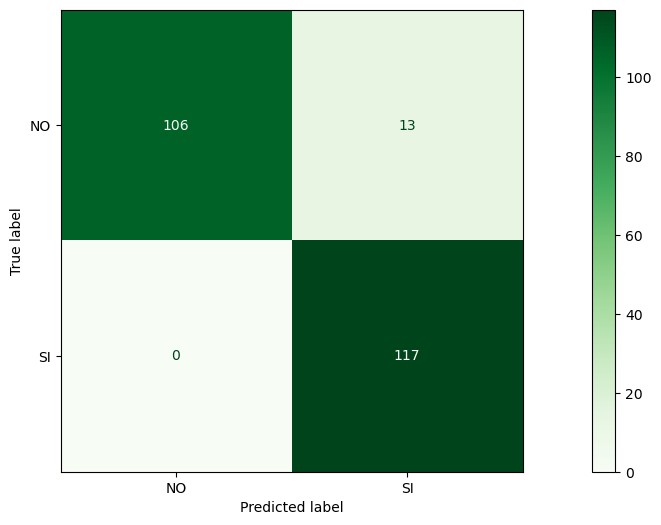

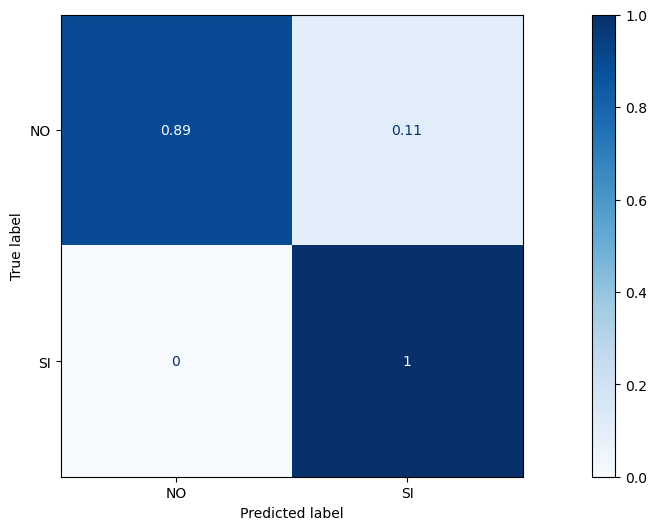

In [24]:
#Evaluamos métricas de DT
mx_display(y_test, y_pred_dt, "Decision Tree", 'Greens', 'Blues')

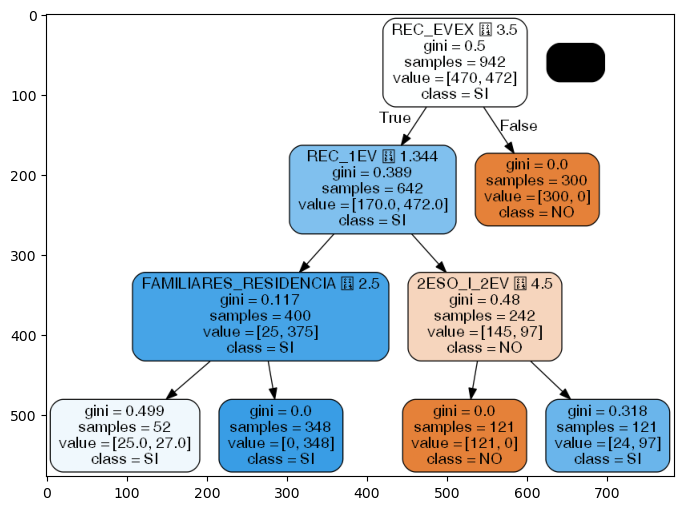

In [32]:
#Dibujamos el árbol para su interpretación

#Extraemos el atributo PROMOCIONA
df_cut = data_augmented.drop(labels=['PROMOCIONA', ], axis=1)

# mostramos el árbol gráifcamente
data = (tree.export_graphviz(best_dt_model, out_file=None, feature_names=data_augmented.columns.values[0:19],
         class_names=['NO', 'SI'], filled=True, rounded=True, special_characters=True))

graph = pydotplus.graph_from_dot_data(data)
graph.write_png('DT_FPB.png')

img = pltimg.imread('DT_FPB.png')
imgplot = plt.imshow(img)
plt.show()
plt.rcParams["figure.figsize"] = (30,10)

In [33]:
'''Interpretación del árbol:

El nodo raíz usa REC_EVEX para dividir las muestras. Si el valor de REC_EVEX es mayor que 3.5, la clase predicha es 0.
Si REC_EVEX es menor o igual a 3.5, se evalúa REC_1EV.'''

'Interpretación del árbol:\n\nEl nodo raíz usa REC_EVEX para dividir las muestras. Si el valor de REC_EVEX es mayor que 3.5, la clase predicha es 0.\nSi REC_EVEX es menor o igual a 3.5, se evalúa REC_1EV.'

In [34]:
#Vemos la importancia de cada variable en el modelo DT
importancia_predictores = pd.DataFrame(
                            {'predictor': df_cut.columns,
                             'importancia': best_dt_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo DT")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo DT
-------------------------------------------


,predictor,importancia
18,REC_EVEX,0.543661
16,REC_1EV,0.213633
14,2ESO_I_2EV,0.191266
6,FAMILIARES_RESIDENCIA,0.051440
10,1ESO_M_1EV,0.000000
17,REC_2EV,0.000000
15,REP_1FPB,0.000000
13,2ESO_EF_1EV,0.000000
12,1ESO_MEDIA_EVF,0.000000
11,1ESO_MEDIA_1EV,0.000000


In [35]:
#Función que devuelve las métricas de los modelos entrenados a partir de un y_test e y_pred

def eval_mod(y_test, y_pred, name_model):
    """
    Funcion que genera las métricas de evaluación del modelo entrenado
    
    Argumentos: datos de test, datos predichos, y nombre del modelo
    Salida: mx, ACC, TPR, precision, errorRate, ICC, ICI, TNR, FPR, BACC, F1, MCC
    """   
    #Matriz de confusión
    mx= confusion_matrix(y_test, y_pred)

    #Calculamos los Tp, Tn, Fp y Fn de cada clase:

    Total = mx.sum()               #Calculamos el total de la muestra (P+N)

    tp = mx[1][1]                 #Valor coincidente de primera fila y primera col
    fp = mx[:,1].sum() - tp      #Sumamos la primera Columna y restamos el tp1
    fn = mx[1].sum() - tp        #Sumamos la primera Fila y restamos el tp1
    tn = Total - tp - fp - fn  #Restando al Total 
    P  = mx[1].sum()              #Positivos (Positive)
    N  = Total - P               #Negativos (Negative)


    #Calculamos Métricas:

    # Accuracy - Exactitud (% de instancias del conjunto que se clasifican correctamente)
    ACC= accuracy_score(y_test, y_pred)
    # Recall - Sensibilidad (TPR)
    TPR= tp/(tp+fn)
    # Precision 
    precision=tp/(tp+fp)
    # Tasa de error (errorRate)
    errorRate = 1 - ACC
    #Instancias clasificadas correctamente
    ICC = tp+tn
    #Instancias clasificadas incorrectamente
    ICI = fn
    #TNR - Especificidad
    TNR = tn/(tn+fp)
    #FPR - Tasa de falsos positivos
    FPR = [round(fp/(N),2), round(fp/(N),2)]
    #BACC
    BACC = balanced_accuracy_score(y_test, y_pred)
    #F1
    F1 = f1_score(y_test, y_pred, average=None)
    #MCC
    MCC = matthews_corrcoef(y_test, y_pred)

    comment='''
    Instancias clasificadas correctamente (ICC): Sumatorio de Verdaderos positvos
    Instancias Clasificadas incorrectamente (ICI): Sumatorio de Falsos positivos
    TPR(Sensibilidad): probabilidad de que un resultado positivo real de positivo.
    TNR(Especificidad): probabilidad de que un resultado negativo real dé un resultado negativo.
    ACC(Exactitud): cantidad de predicciones positivas que fueron correctas.
    FPR (Tasa de falsos positivos): probabilidad de que se produzca una falsa alarma.
    Precisión: porcentaje de instancias positivas respecto al total de predichas como positivas.
    Tasa de error (ErrorRate): porcentaje de instancias clasificadas incorrectamente.
    BACC (Balanced Accuracy): ACC balanceado a las 4 clases
    MCC (Matthews correlation coefficient)
    '''

    print('MÉTRICAS PARA EVALUACIÓN DEL %s:\n' % (name_model))
    print("The Classification Report is \n:",classification_report(y_test, y_pred))
    print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp, 'P:', P, 'N:', N)
  
    print("\nInstancias clasificadas correctamente:", ICC)
    print("\nInstancias clasificadas incorrectamente:", ICI)
    print("\nAccuracy: \n", ACC)
    print("\nErrorRate: \n", round(errorRate,2))
    print("\nSensibilidad: \n", TPR)
    print("\nEspecificidad: \n", TNR)
    print("\nPrecision: \n", precision)
    print("\nBACC: \n", BACC)
    print("\nMCC: \n", MCC)
    print("\nMatriz de confusión: \n", mx)    

    return mx, ACC, TPR, precision, errorRate, ICC, ICI, TNR, FPR, BACC, F1, MCC

In [36]:
#Evaluamos métricas de DT
mx, ACC, TPR, precision, errorRate, ICC, ICI, TNR, FPR, BACC, F1, MCC = eval_mod(y_test, y_pred_dt, "Decision Tree")

MÉTRICAS PARA EVALUACIÓN DEL Decision Tree:

The Classification Report is 
:               precision    recall  f1-score   support

           0       1.00      0.89      0.94       119
           1       0.90      1.00      0.95       117

    accuracy                           0.94       236
   macro avg       0.95      0.95      0.94       236
weighted avg       0.95      0.94      0.94       236

tn: 106 fp: 13 fn: 0 tp: 117 P: 117 N: 119

Instancias clasificadas correctamente: 223

Instancias clasificadas incorrectamente: 0

Accuracy: 
 0.9449152542372882

ErrorRate: 
 0.06

Sensibilidad: 
 1.0

Especificidad: 
 0.8907563025210085

Precision: 
 0.9

BACC: 
 0.9453781512605042

MCC: 
 0.8953662224301896

Matriz de confusión: 
 [[106  13]
 [  0 117]]
